# Introduction : objectives

The ecophysiological and biogeochemical properties of certain zones in the footprint area can influence the observed functioning of the ecosystem. This is particularly true for the wetland near the Lautaret station, where soil moisture is a key factor in microbial decomposition. The objective is to analyze the relative contribution of the wetland to the dynamics of carbon sequestration and emission of the ecosystem.

# Importation of packages and modules

This notebook was developed with:  
- Python 3.13.2  
- Jupyter Notebook  
- Libraries : pandas, numpy, matplotlib, hesseflux, geopandas, shapely, contextily, statsmodels, scipy, seaborn  
- Modules : data_preparation, footprint_analysis
- See 'environment.yml' in the repository for more infos. 

In [1]:
import sys
sys.path.append('/home/jovyan//ICOS-M2-internship-alise/scripts/')

In [320]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import data_preparation as datprep
import footprint_analysis as FFP_analys
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import nee2gpp_hesseflux as nee2gpp_hf
import geopandas as gpd
from shapely.geometry import box, Point
import contextily as cx
import matplotlib.lines as mlines
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.signal as sg
import glob
import os
from tqdm import tqdm
from rasterio.features import shapes
from affine import Affine
from shapely.geometry import shape
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import anderson
from scipy.stats import mannwhitneyu
from collections import Counter
import calendar

#Pour mettre à jour les modules
import importlib
importlib.reload(datprep)
importlib.reload(FFP_analys)

import watermark
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [205]:
%watermark --iversions

scipy              : 1.15.2
statsmodels        : 0.14.4
rasterio           : 1.4.3
tqdm               : 4.67.1
affine             : 2.4.0
xarray             : 2025.3.1
shapely            : 2.0.7
geopandas          : 1.0.1
pandas             : 2.2.3
contextily         : 1.6.2
rioxarray          : 0.19.0
sys                : 3.13.2 | packaged by conda-forge | (main, Feb 17 2025, 14:10:22) [GCC 13.3.0]
watermark          : 2.5.0
seaborn            : 0.13.2
numpy              : 2.2.4
matplotlib         : 3.10.1
matplotlib_scalebar: 0.9.0



# 1) Spatial sectorization of the wetland

In [51]:
# Set tower coordinates (longitude and latitude in WGS84, EPSG : 4326)
lon_tower = 6.410519
lat_tower = 45.041375

In [52]:
# Convert tower coordinates into Lambert 93
x0_zh, y0_zh = FFP_analys.transform_coordinates(lon_tower, lat_tower, crs_in="EPSG:4326", crs_out="EPSG:2154")

In [62]:
# Convert the tower position into a geodataframe object (point)
tower_gdf = gpd.GeoDataFrame({"name": ["Tour"]}, geometry=[Point(x0_zh, y0_zh)], crs="EPSG:2154")

In [54]:
# Import the hydrographic surfaces georeferenced by IGN
hydro = gpd.read_file('/mnt/data-summer-shared/ICOS_Data_AliseROBERT/SURFACE_HYDROGRAPHIQUE.shp')

In [57]:
# Create a bounding box around the flux tower
domain_size = 700
xmin, ymin = x0_zh - domain_size, y0_zh - domain_size
xmax, ymax = x0_zh + domain_size, y0_zh + domain_size
bbox = box(xmin, ymin, xmax, ymax)

In [58]:
# Crop the hydrographic surfaces with this box
hydro_cropped = gpd.clip(hydro, bbox)

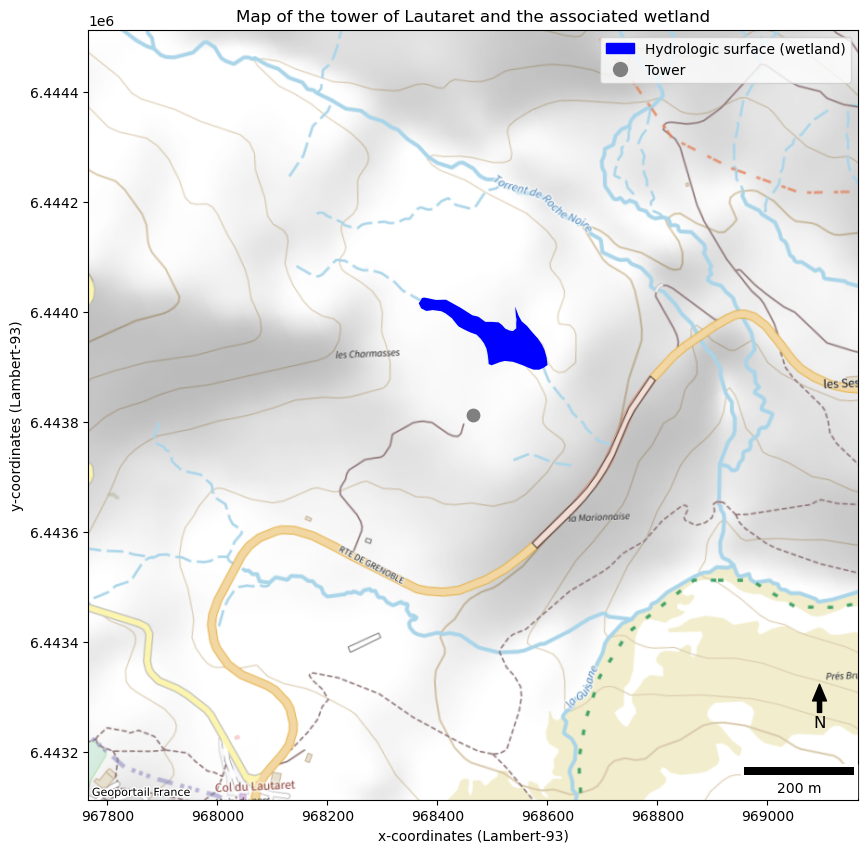

In [64]:
# Plot the hydrographic surface near the flux tower
fig, ax = plt.subplots(figsize=(10, 10))

# Add hydrography
hydro_cropped.plot(ax=ax, color="blue", linewidth=0.5)

# Add the tower
tower_gdf.plot(ax=ax, color="grey", markersize=80)

# Set the map limits
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Import the background map from Geoportail
cx.add_basemap(ax, crs="EPSG:2154", source=cx.providers.GeoportailFrance.plan, alpha=1)

#Add a legend
hydro_patch = mpatches.Patch(color="blue", label="Hydrologic surface (wetland)")
tower_point = mlines.Line2D([], [], color="grey", marker="o", linestyle="None", markersize=10, label="Tower")

ax.legend(handles=[hydro_patch, tower_point], loc="upper right")

# Scale bar
scalebar = ScaleBar(1, units="m", dimension="si-length", location="lower right")
ax.add_artist(scalebar)

# North arrow
x, y, arrow_length = 0.95, 0.15, 0.05
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=3, headwidth=10),
            ha='center', va='center', fontsize=12,
            xycoords=ax.transAxes)
plt.title('Map of the tower of Lautaret and the associated wetland')
plt.xlabel('x-coordinates (Lambert-93)')
plt.ylabel('y-coordinates (Lambert-93)')
plt.show()

Within the measurement area, in the immediate vicinity of the flux tower, there is a wetland that may have an impact on the carbon captured by the sensor. Indeed, because of its biogeochimc characteristics and in particular its high water content, soil microorganisms may respire less. **It is therefore necessary to know the exact contribution of this area to the measured flux, in order to quantify its effect on the observed functioning of the ecosystem.**

# 2) Calculation of its relative contribution

**Warning : the following cell is particularly time-consuming, only run it if necessary**

In [145]:
#all_timestamps = []
#all_contributions = []
#pixel_size = 2.5

# Get all nc files from the folder
#folder_path = '../private-storage/data-runs-daily/'
#nc_files = glob.glob(os.path.join(folder_path, '*.nc'))

#for file in tqdm(nc_files, desc = 'Processing netCDF files'):
    #try:
        #with xr.open_dataset(file) as dataset:
            #timestamp = dataset['timestamp'].values

            # For each timestamp, get the footprint values and create a mask for positive values
            #for i, t in enumerate(timestamp):
                #fp_dataset = dataset.isel(timestamp=i)
                #footprints = fp_dataset['footprint'].values
                #mask = footprints > 0

                # Reconstruct the 2D grid
                #x, y = np.meshgrid(x0_zh + fp_dataset['x'].values, y0_zh + fp_dataset['y'].values)

                # Create an affine transformation (set the origin and then scale the grid with the pixel size)
                #transform = Affine.translation(x[0, 0] - pixel_size / 2, y[0, 0] - pixel_size / 2) * Affine.scale(pixel_size, pixel_size)
                # Extract polygons using the mask and the affine transform for georeferencing
                #shapes_gen = shapes(footprints, mask=mask, transform=transform)

                #geoms = []
                #values = []

                # Store each pixel (polygone) and its value
                #for geom, val in shapes_gen:
                    #geoms.append(shape(geom))
                    #values.append(val)

                # Build a GeoDataFrame from the polygons and their footprint values
                #foot_gdf = gpd.GeoDataFrame({'footprint': values}, geometry=geoms, crs='EPSG:2154')
                # Perform a geometric intersection between footprint polygons and the wetland
                #intersection = gpd.overlay(foot_gdf, hydro_cropped, how = 'intersection')

                # Sum up the footprint values of the intersected areas: this represents the total contribution of the wetland
                #total_contribution = intersection['footprint'].sum()
                
                #all_contributions.append(total_contribution)
                #all_timestamps.append(t)

    #except Exception as e:
        #print(f'Error with file {file} : {e}')

# Create a dataframe with the contribution of the wetland for each timestamp
#contrib_df = pd.DataFrame({'Timestamp' : all_timestamps, 'Contribution' : all_contributions})

# Save this to csv
#contrib_df.to_csv('/home/jovyan/private-storage/relativecontributionZH.csv', index = False)

In [251]:
# Open the csv file. Because a lot of data is missing for 2019, it will not be taken into account
ZH_contrib_20_24 = pd.read_csv('/home/jovyan/private-storage/relativecontributionZH_20_24.csv')

In [252]:
# Calculate the maximum contribution of the wetland to the carbon flux
max_contrib = ZH_contrib_20_24['Contribution'].max()
max_contrib

np.float64(0.0262907783705029)

Text(0.5, 1.0, 'Distribution of relative contribution values')

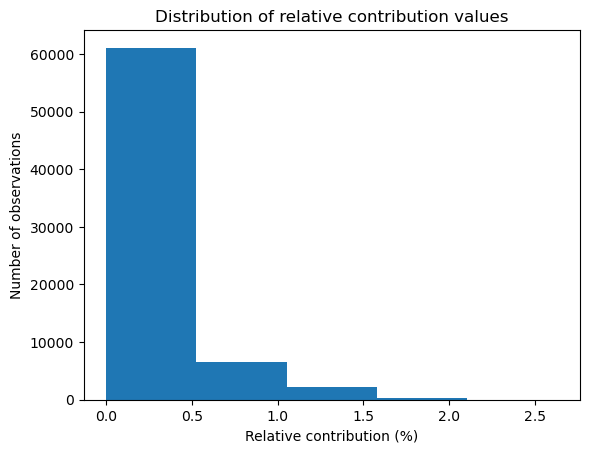

In [150]:
# Plot a histogram to visualize the distribution of the data
plt.hist(ZH_contrib_20_24['Contribution']*100, 5)
plt.xlabel('Relative contribution (%)')
plt.ylabel('Number of observations')
plt.title('Distribution of relative contribution values')

**Although it is located in the immediate vicinity of Lautaret flux tower, within the contour of the 90% contribution to the measured signal, the wetland is only very little captured by the station. Indeed, more than three-quarters of the time, its relative importance in the measurement is less than 0.5%. For certain conditions, this value can reach 2.6%, which remains very low.**

In [151]:
# Add phase info
flux_NDVI = pd.read_csv('flux_NDVI.csv')
flux_NDVI["TIMESTAMP_START"] = pd.to_datetime(flux_NDVI["TIMESTAMP_START"])
ZH_contrib_20_24['TIMESTAMP_START'] = pd.to_datetime(ZH_contrib_20_24['Timestamp'])
ZH_contrib_plot = pd.merge(ZH_contrib_20_24, flux_NDVI[['phase_label', 'Night','TIMESTAMP_START']], on='TIMESTAMP_START')

In [152]:
# Adapt the dataframe to plot new histograms (change True/False into Night/Day and convert Contribution values into %)
ZH_contrib_plot['Night'] = ZH_contrib_plot['Night'].map({True: 'Night', False: 'Day'})
ZH_contrib_plot['Contribution'] *= 100

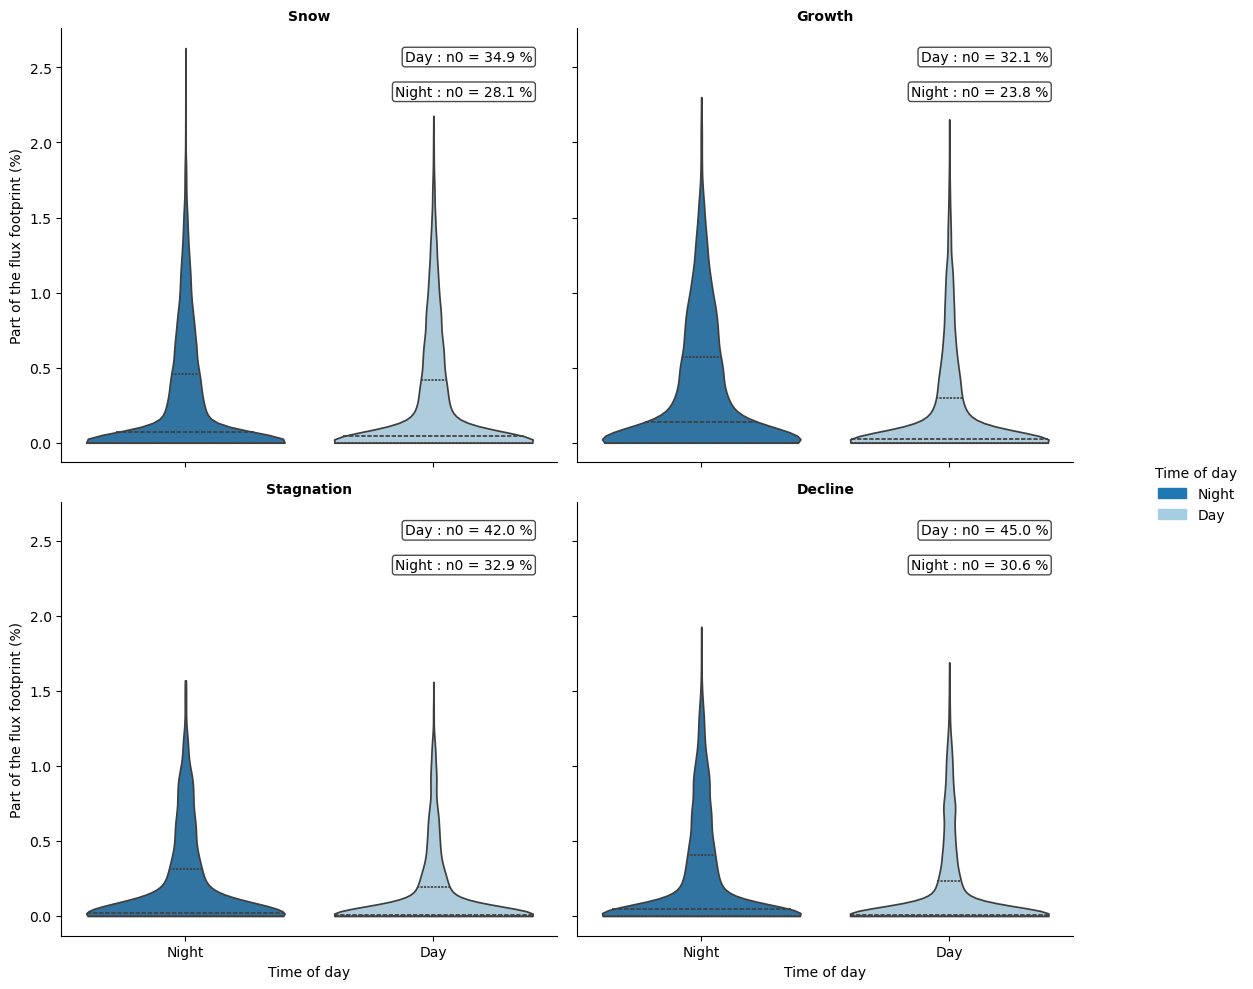

In [153]:
# Set the color palet for Night and Day
legend_data = {
    'Night': mpatches.Patch(color='#1F78B4'), 
    'Day': mpatches.Patch(color='#A6CEE3'), 
}

# Create FacetGrid
g = sns.FacetGrid(
    ZH_contrib_plot,
    col='phase_label',
    col_wrap=2,
    height=5,
    sharey=True
)

# Function to plot violin plots and add the proportion of zero
def plot_hist_with_zero_text(data, color, **kwargs):
    ax = plt.gca()
    
    # Histograms of contribution > 0 for Night/Day
    sns.violinplot(
        data=data[data['Contribution'] > 0],
        x='Night',
        y='Contribution',
        hue='Night',
        hue_order=['Day', 'Night'],
        inner ='quartile',
        cut=0,
        palette='Paired',
    )
    
    # Counting zeros by modality
    night_values = data['Night'].dropna().unique()
    
    for i, night_val in enumerate(sorted(night_values)):
        count_zeros = data[(data['Contribution'] == 0) & (data['Night'] == night_val)].shape[0]
        count_total = data[(data['Contribution'] >= 0) & (data['Night'] == night_val)].shape[0]
        
        if count_zeros > 0:
            # Add boxed text
            ax.text(
                0.95,                           
                0.95 - i * 0.08,                 
                f"{night_val} : n0 = {round(count_zeros/count_total*100, 1)} %",
                transform=ax.transAxes,
                fontsize=10,
                color='black',
                ha='right',
                va='top',
                bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.7)
            )

    
# Apply the function to each subplot
g.map_dataframe(plot_hist_with_zero_text)

# Formatting
g.set_axis_labels("Time of day", "Part of the flux footprint (%)")
g.set_titles("{col_name}", fontweight = 'bold')
g.add_legend(legend_data = legend_data, title="Time of day", bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.tight_layout()
plt.savefig('violinplots_contrib_zh.png')
plt.show()

The percentage of observations where the flux footprint is zero is given for each case by n0. The remaining values (contribution>0) are represented as violin plots. The median and third quartile are shown as dashed and dotted lines, respectively. The contribution of the wetland appears to be lower for the phases of stagnation and decline of vegetation. The percentage of zero contribution is also higher there (up to 45%). When there is snow or the grassland is growing, the wetland is captured more. This trend is accentuated at night, especially for the "growth" stage where the quartiles appear visually higher. The contribution of the wetland then is dependent on meteorological and atmospheric conditions.

# 3) Flux partitioning

In [154]:
# Filtered data importation
filtered_data = pd.read_csv('filtered_data.csv', index_col="TIMESTAMP_START", parse_dates=True)

In [155]:
# All NaN values are set to undef and will be ignored in the following
undef = -9999.
ready_data = filtered_data.copy()
ready_data.fillna(undef, inplace=True)

In [156]:
# Create adequate inputs for hesseflux nee2gpp function
isday = ~filtered_data['Night'].to_numpy()

In [157]:
# Flux partitioning with Reichstein method (based on nighttime data)
partitioned_data = nee2gpp_hf.nee2gpp(ready_data[['FC_1_1_1', 'TA_1_1_1']], isday=isday, nogppnight=False)

/home/jovyan/my-conda-envs/env-ICOS/lib/python3.13/site-packages/scipy/optimize/_minpack_py.py:497: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
/home/jovyan//ICOS-M2-internship-alise/scripts/nee2gpp_hesseflux.py:643: OptimizeWarning: Covariance of the parameters could not be estimated
  p1, c = opt.curve_fit(lloyd_fix, tt1[mm], net1[mm],


/tmp/ipykernel_41287/4018561588.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  partitioned_data['GPP'].replace(-9999., np.nan, inplace=True)
/tmp/ipykernel_41287/4018561588.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpla

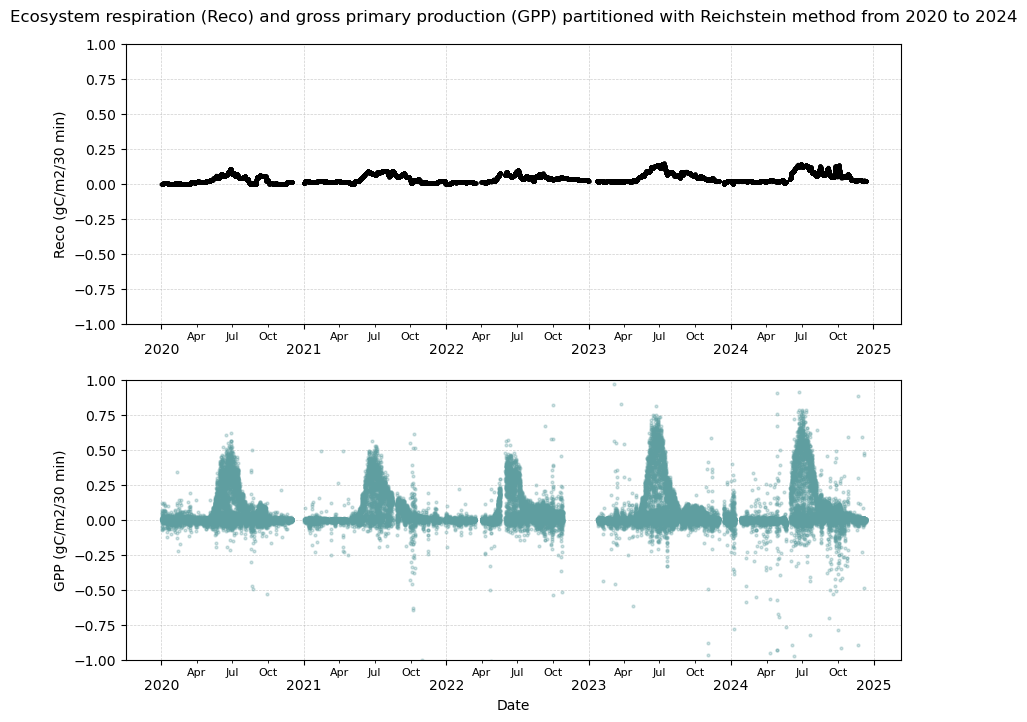

In [158]:
# Plot the outputs : RECO and GPP
partitioned_data['GPP'].replace(-9999., np.nan, inplace=True)
partitioned_data['RECO'].replace(-9999., np.nan, inplace=True)

fig, ax = plt.subplots(2,1,figsize=(10,8))

ax[0].plot(partitioned_data.index, partitioned_data['RECO'], 'o', color='black', alpha=0.3, markersize=2)
ax[0].set_ylim(-1,1)
ax[0].set_ylabel("Reco (gC/m2/30 min)")
ax[1].plot(partitioned_data.index, partitioned_data['GPP'], 'o', color='cadetblue', alpha=0.3, markersize=2)
ax[1].set_ylim(-1,1)
ax[1].set_ylabel("GPP (gC/m2/30 min)")
ax[1].set_xlabel('Date')

for axi in ax:
    # major ticks : years
    axi.xaxis.set_major_locator(mdates.YearLocator())
    axi.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    # minor ticks : months
    axi.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))
    axi.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

    axi.tick_params(axis="x", which="major", labelsize=10, pad=10)  # années
    axi.tick_params(axis="x", which="minor", labelsize=8)
    axi.tick_params(axis="x", which='both', labelbottom=True)

    axi.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

plt.title("Ecosystem respiration (Reco) and gross primary production (GPP) partitioned with Reichstein method from 2020 to 2024", y=2.25)
plt.show()

From the nighttime data, the raw observed NEE can be divided into its 2 components: Reco and GPP. These results are necessary for a precise understanding of the functioning of the ecosystem. These graphs show a peak of carbon sequestration and increased respiration during the plant growing season.

In [159]:
# Add these two components to the filtered dataframe
partitioned_all = partitioned_data.join(filtered_data)

In [160]:
# Replace -9999. by NaN
partitioned_all.replace(-9999., np.nan, inplace=True)

# 4) Statistical comparison (NEE, Reco, GPP)

## Normality test (Anderson-Darling)

Text(0.5, 1.0, 'Histogram of the distribution of carbon flux values')

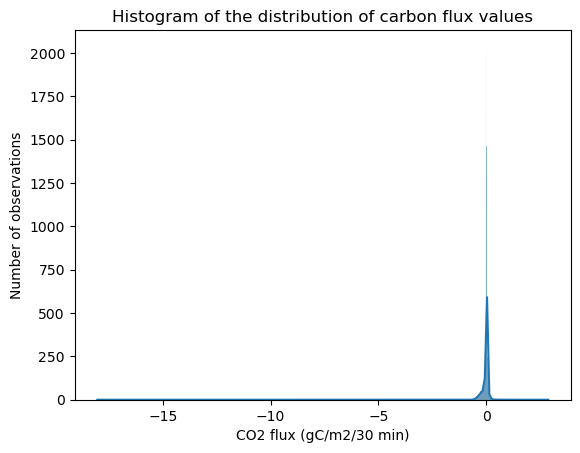

In [181]:
# Histogram of the distribution of carbon flux values
sns.histplot(partitioned_all['FC_1_1_1'].dropna(), kde=True) # kde : compute a kernel density estimate to smooth the distribution and show on the plot as (one or more) line(s)
plt.xlabel('CO2 flux (gC/m2/30 min)')
plt.ylabel('Number of observations')
plt.title('Histogram of the distribution of carbon flux values')

Text(0.5, 1.0, 'Quantile-quantile plot for carbon flux values')

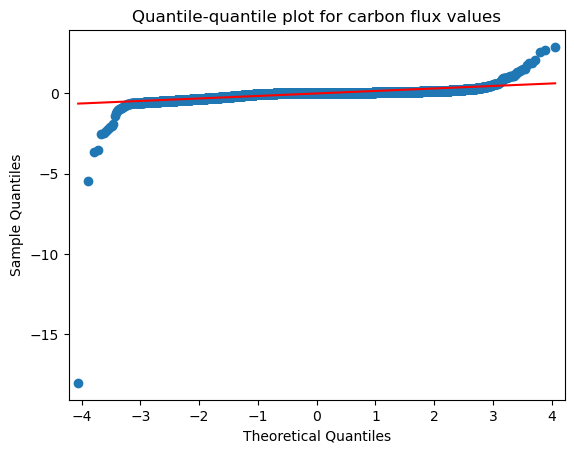

In [183]:
# Quantile-quantile plot
sm.qqplot(partitioned_all['FC_1_1_1'].dropna(), line = 's')
plt.title('Quantile-quantile plot for carbon flux values')

These two graphs show the distribution of carbon flux values and how it diverges from the normal distribution, especially at the extremes.

In [184]:
# Anderson-Darling test : suitable for large datasets
anderson(partitioned_all['FC_1_1_1'].dropna(), dist='norm')

AndersonResult(statistic=np.float64(4822.811572005485), critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(-0.012870030875056976), scale=np.float64(0.1555796384198201))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

The Anderson-Darling test statistic is equal to 4822, which is greater thant any critical value for any significance level. So the flux data are not from a normal distribution. Therefore, for statistical comparisons, non-parametric tests are needed.

## Data preparation and binning

In [161]:
# Add the wetland contribution to the partitioned data
partitioned_all = partitioned_all.merge(ZH_contrib_20_24[['TIMESTAMP_START', 'Contribution']], on='TIMESTAMP_START', how='left')

In [162]:
# Create a new column with "Wetland" when the contribution is greater or equal to 50% of its maximum value, else "Other"
partitioned_all['Wetland'] = 'Other'
partitioned_all.loc[partitioned_all['Contribution'] >= max_contrib*0.5, 'Wetland'] = 'Wetland'

In [163]:
# Count the number of timestamps where the contribution is greater or equal to 50% of its maximum value
partitioned_all['Wetland'].value_counts()

Wetland
Other      85713
Wetland     1071
Name: count, dtype: int64

In [164]:
# Set a datetime index
partitioned_all['TIMESTAMP_START'] = pd.to_datetime(partitioned_all['TIMESTAMP_START'])
partitioned_all = partitioned_all.set_index('TIMESTAMP_START')

In [165]:
# Create a flag for the temperature (1 f it is missing, else 0)
ta_flag = partitioned_all['TA_1_1_1'].copy(deep=True)
ta_flag[:] = 0
ta_flag[partitioned_all['TA_1_1_1'].isna()] = 1

In [166]:
# Create a flag for the vapor pressure deficit (1 f it is missing, else 0)
vpd_flag = partitioned_all['VPD_1_1_1'].copy(deep=True)
vpd_flag[:] = 0
vpd_flag[partitioned_all['VPD_1_1_1'].isna()] = 1

In [167]:
# Create a flag for the shortwave incoming radiation (1 f it is missing, else 0)
sw_flag = partitioned_all['SW_IN_1_1_1'].copy(deep=True)
sw_flag[:] = 0
sw_flag[partitioned_all['SW_IN_1_1_1'].isna()] = 1

In [168]:
# Create a flag for the carbon flux (1 f it is missing, else 0)
data_flag = partitioned_all['FC_1_1_1'].copy(deep=True)
data_flag[:] = 0
data_flag[partitioned_all['FC_1_1_1'].isna()] = 1

In [169]:
meteo_flag = (ta_flag == 0) & (vpd_flag == 0) & (sw_flag == 0) # Is True if all meteorological variables are available
total_flag = meteo_flag & (data_flag == 0) # True if both meteo and data are available

In [170]:
# Create separated variables
sw = partitioned_all['SW_IN_1_1_1'].to_numpy()
ta = partitioned_all['TA_1_1_1'].to_numpy()
vpd = partitioned_all['VPD_1_1_1'].to_numpy()
nee = partitioned_all['FC_1_1_1'].to_numpy()
reco = partitioned_all['RECO'].to_numpy()
gpp = partitioned_all['GPP'].to_numpy()

In [171]:
# Define a time window
week = pd.Timedelta('1 W') / (partitioned_all.index[1] - partitioned_all.index[0]) # Number of half hour in one week

In [185]:
# Find bins that as similar meteorological conditions within the time window, with a minimum of 5 observations to perform the statistical test
bins_data = []

for j in range(len(partitioned_all)):
        # Threshold for "similar" meteo conditions
        sw_devmax = np.maximum(20., np.minimum(sw[j], 50.))
        ta_dev = 2.5
        vpd_dev = 500.

        if data_flag.iloc[j] == 0:
            if meteo_flag.iloc[j]:
                j1 = j - np.arange(1, week + 1, dtype=int) + 1
                j2 = j + np.arange(1, week, dtype=int)
                jj = np.append(j1, j2)
                window = np.unique(np.sort(np.clip(jj, 0, len(partitioned_all) - 1))) # Define the 1 W window around the timestamp

                # "conditions" is true when none of the meteorological variables exceeds its maximum deviation
                conditions = ((np.abs(sw[window] - sw[j]) < sw_devmax) & (np.abs(ta[window] - ta[j]) < ta_dev) & (np.abs(vpd[window] - vpd[j]) < vpd_dev) & total_flag.iloc[window])
                similar_idx = window[conditions]
                num_similar= len(similar_idx) # Give the number of NEE with similar conditions

                if num_similar >= 10: 
                    sectors = partitioned_all.iloc[similar_idx]['Wetland']
                    sector_counts = pd.Series(sectors).value_counts()

                    # Keep only the sectors with a minimum of 5 observations
                    valid_sectors = sector_counts[sector_counts >= 5]
                    valid_index = valid_sectors.index

                    # Filter the index for valid sectors
                    valid_mask = sectors.isin(valid_index)
                    filtered_idx = similar_idx[valid_mask.to_numpy()]

                    if (len(valid_sectors) == 2):
                        bin_df = pd.DataFrame({
                            'NEE': nee[filtered_idx],
                            'RECO':reco[filtered_idx],
                            'GPP':gpp[filtered_idx],
                            'Sector': partitioned_all.iloc[filtered_idx]['Wetland'].values,
                            'TA': ta[filtered_idx],
                            'VPD': vpd[filtered_idx],
                            'SW_IN': sw[filtered_idx],
                            'Time': partitioned_all.index[filtered_idx]
                        })
                        bins_data.append(bin_df)

In [186]:
len(bins_data)

335

In [188]:
# Concatenate the bins and add hour, month and year columns
df_bins_all = pd.concat(bins_data, ignore_index=True)
df_bins_all['Hour'] = df_bins_all['Time'].dt.hour
df_bins_all['Month'] = df_bins_all['Time'].dt.month
df_bins_all['Year'] = df_bins_all['Time'].dt.year

Text(0.5, 0.98, 'Distribution of the observations with similar meteo as a function of hour, month and year')

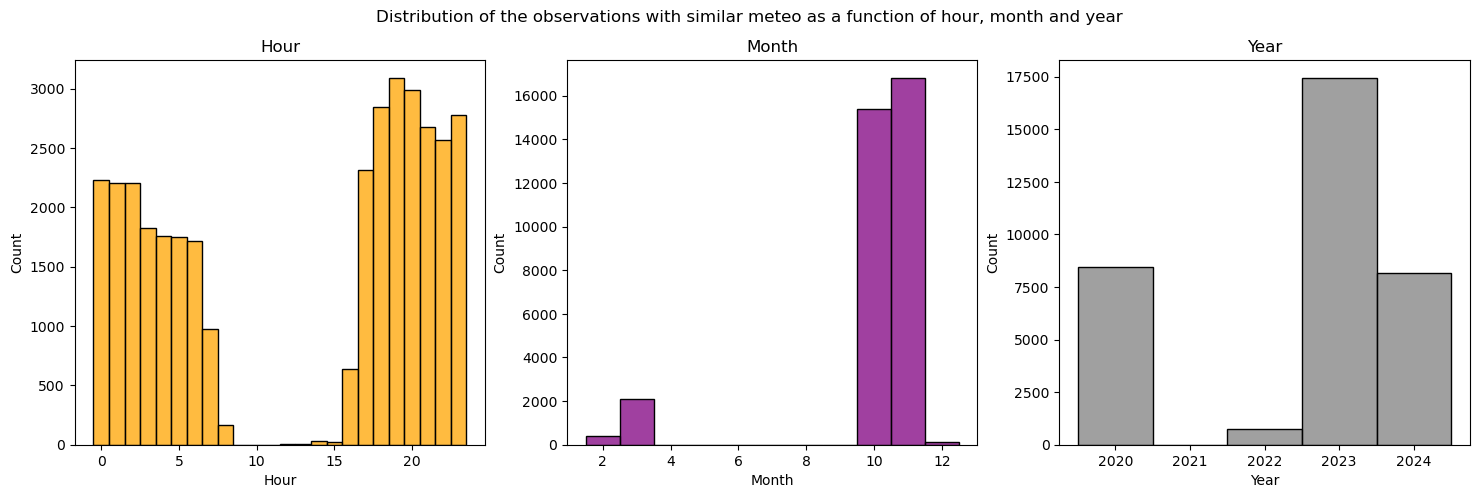

In [191]:
# Check the characteristics of the periods where the meteorological conditions are similar and there are enough observations to perform statistical tests
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(df_bins_all['Hour'], bins=24, discrete=True, ax=axes[0], color='orange')
axes[0].set_title('Hour')

sns.histplot(df_bins_all['Month'], bins=12, discrete=True, ax=axes[1], color='purple')
axes[1].set_title('Month')

sns.histplot(df_bins_all['Year'], bins=(2019,2020,2021,2022,2023), discrete=True,ax=axes[2], color='grey')
axes[2].set_title('Year')
plt.suptitle('Distribution of the observations with similar meteo as a function of hour, month and year')

Among the measurements most impacted by the wetland, only 335 points are comparable with data that are very little or not influenced. These are mainly night fluxes, ocurring in October and November (and to a lesser extent February and March), for the years 2020, 2023 and 2024.

## Mann-Withney U test: Wetland VS Other

### NEE

In [270]:
# Comparison of NEE values between the two sectors, using the Mann-Whitney U test and summary of the significant differences
bin_significant_NEE, summary_df_NEE = FFP_analys.comparison_test(bins_data, 'NEE')

8
Counter({'Other > Wetland': 8})


#### NEE Other > NEE Wetland

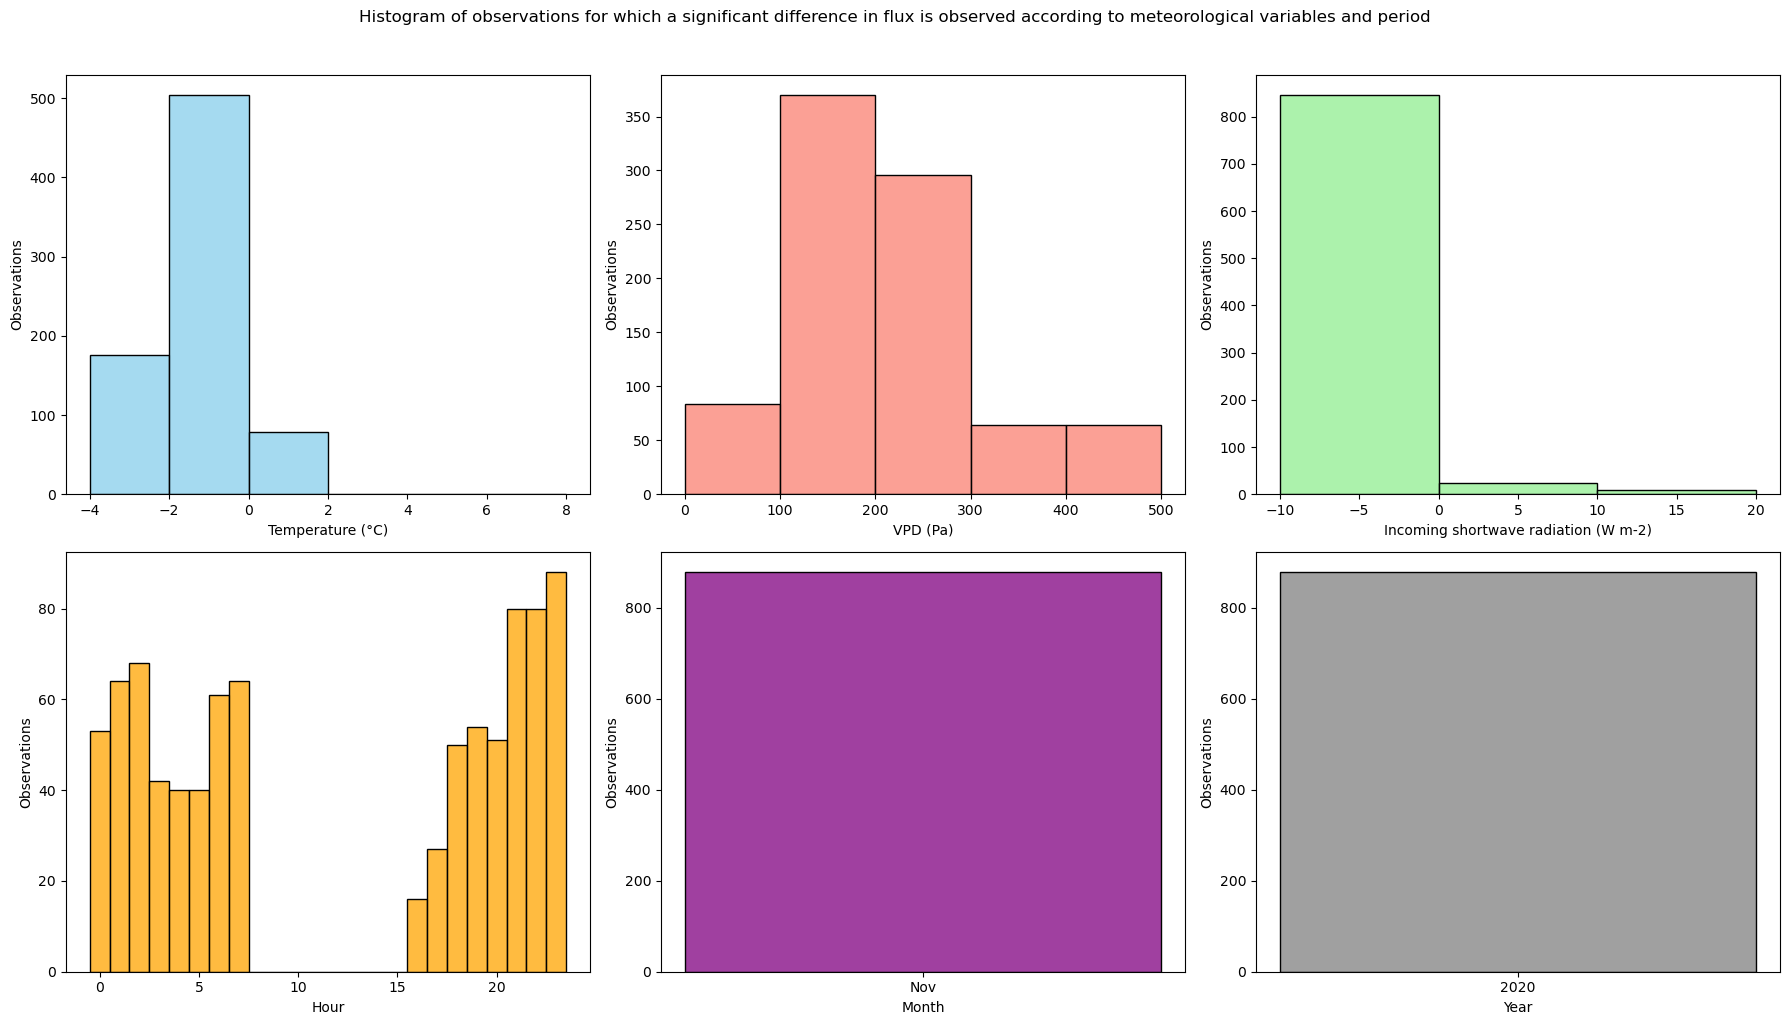

In [321]:
# Histograms of meteorological and temporal conditions for bins with significant sector differences
fig = FFP_analys.hist_significant(bin_significant_NEE, summary_df_NEE, 'Other > Wetland')
fig.savefig('NEEinf_distrib.png')
plt.show()

There are 8 bins with similar meteorological conditions where the NEE of the wetland is significantly lower than the other observations. This occured at specific times : in nights of November 2020, for low temperatures and high humidity. The median NEE of the fluxes where the wetland contributed the most is 0.34 gC/m2/day, while it is 0.53 gC/m2/day for the rest of the measured fluxes.

In [228]:
# Concatenate the significant bins
all_bins = pd.concat(bin_significant_NEE, ignore_index=True)
# Calculate the global median value
sectored_nee_df = all_bins.groupby('Sector')['NEE'].median().reset_index()
sectored_nee_df

,Sector,NEE
0,Other,0.011143
1,Wetland,0.007005


### GPP

In [258]:
# Comparison of GPP values between the two sectors, using the Mann-Whitney U test and summary of the significant differences
bin_significant_GPP, summary_df_GPP = FFP_analys.comparison_test(bins_data, 'GPP')

6
Counter({'Other < Wetland': 6})


#### GPP Other < GPP Wetland

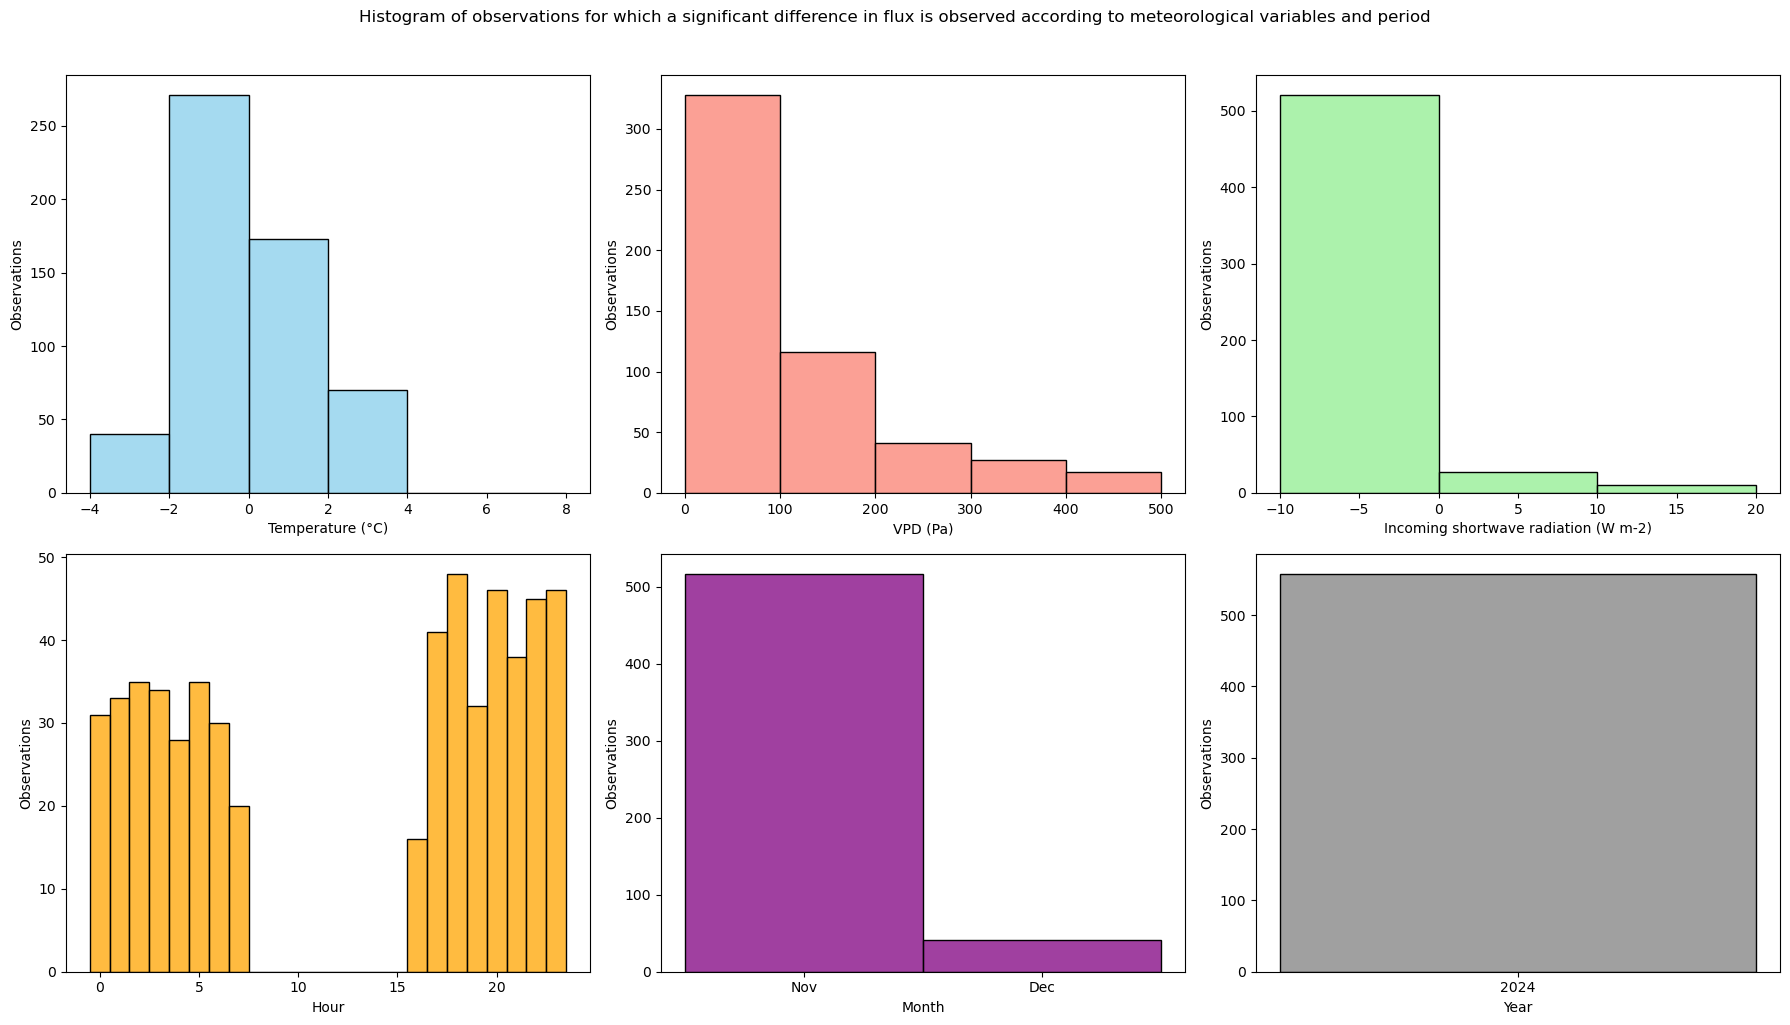

In [322]:
# Histograms of meteorological and temporal conditions for bins with significant sec<tor differences
fig = FFP_analys.hist_significant(bin_significant_GPP, summary_df_GPP, 'Other < Wetland')
plt.show()

There are 6 bins with similar meteorological conditions where the GPP of the wetland is significantly higher than the other observations. This occured at specific times : in nights of November and December 2024, for low temperatures and high humidity. The median GPP of the fluxes where the wetland contributed the most is 0.27 gC/m2/day, while it is -0.029 gC/m2/day for the rest of the measured fluxes. However, there is no photosynthesis during the night but the GPP can be negative : it reflects the uncertainty in the gross flux estimate but can hardly be linked to a concrete process in the functioning of the ecosystem.

In [240]:
# Concatenate the significant bins
all_bins = pd.concat(bin_significant_GPP, ignore_index=True)
# Calculate the global median value
sectored_gpp_df = all_bins.groupby('Sector')['GPP'].median().reset_index()
sectored_gpp_df

,Sector,GPP
0,Other,-0.000598
1,Wetland,0.005537


### Reco

In [259]:
# Comparison of Reco values between the two sectors, using the Mann-Whitney U test and summary of the significant differences
bin_significant_RECO, summary_df_RECO = FFP_analys.comparison_test(bins_data, 'RECO')

89
Counter({'Other < Wetland': 66, 'Other > Wetland': 23})


#### Reco Other < Reco Wetland

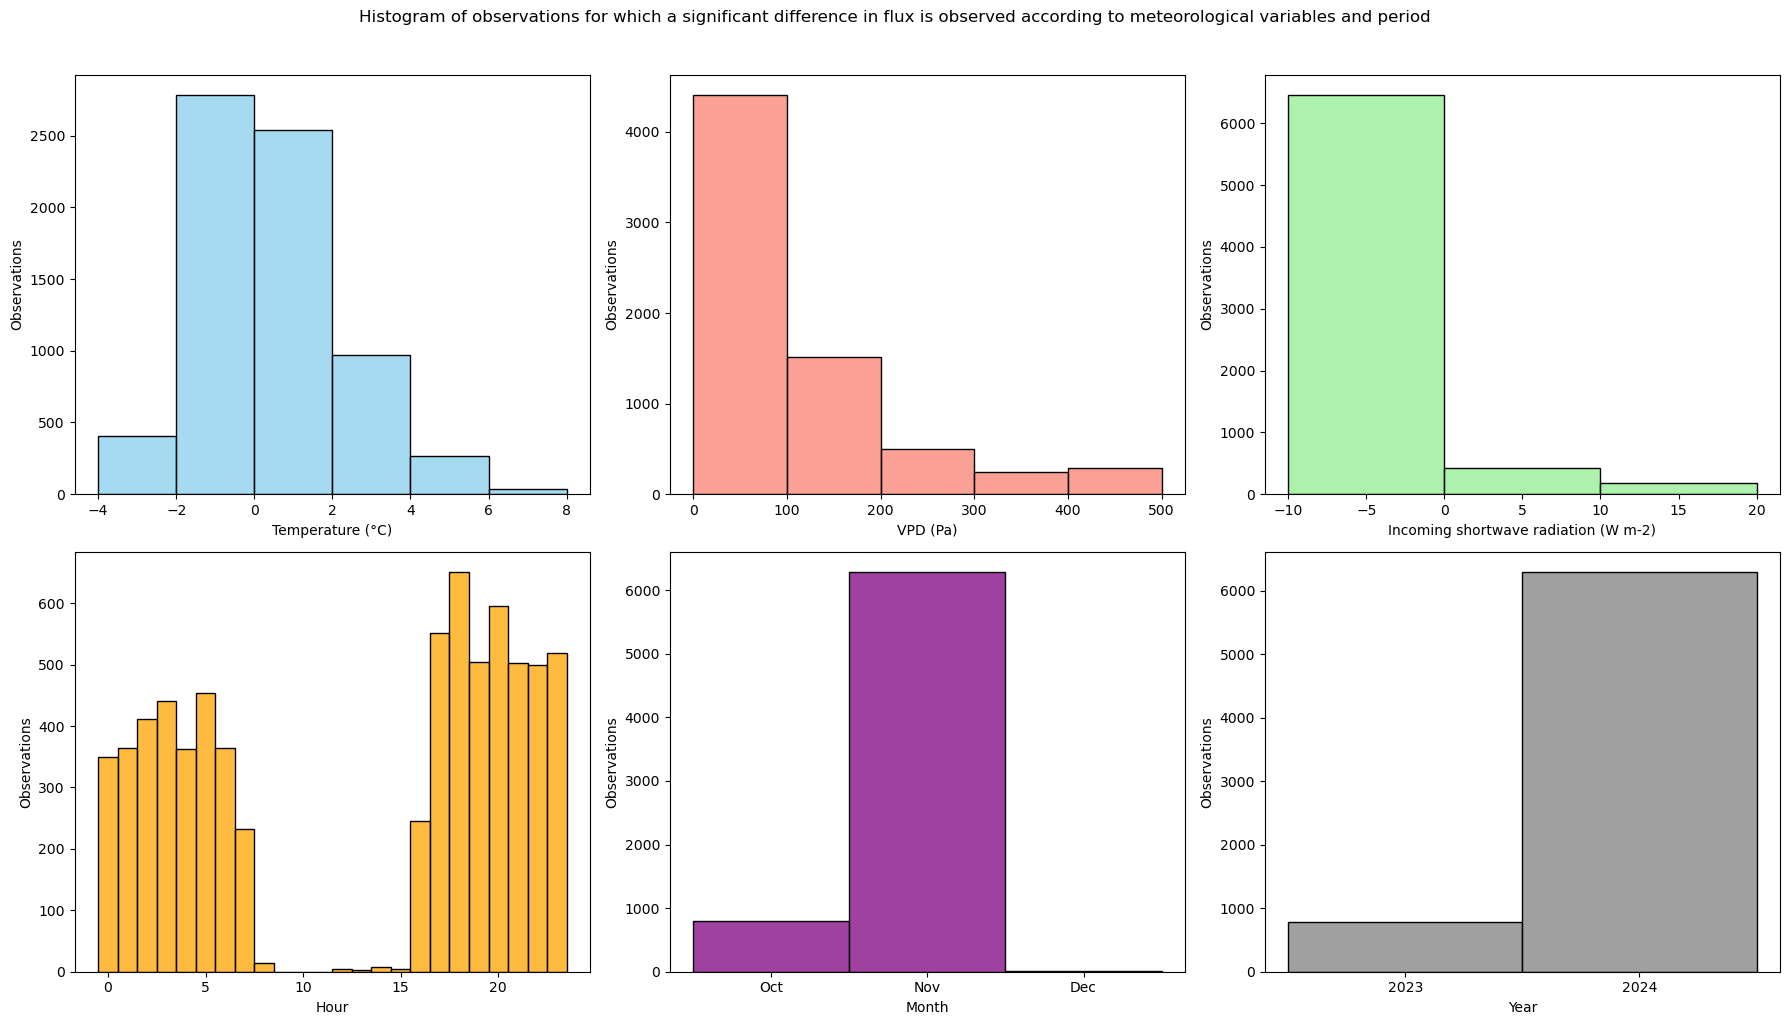

In [323]:
# Histograms of meteorological and temporal conditions for bins with significant sector differences
fig = FFP_analys.hist_significant(bin_significant_RECO, summary_df_RECO, 'Other < Wetland')
fig.savefig('RECOsup_distrib.png')
plt.show()

There are 66 bins with similar meteorological conditions where the Reco of the wetland is significantly higher than the other observations. This occured at specific times : in nights of November and October 2024 (and sometimes 2023), for low temperatures and high humidity. The median Reco of the fluxes where the wetland contributed the most is 1.33 gC/m2/day, while it is 1.17 gC/m2/day for the rest of the measured fluxes.

#### Reco Other > Reco Wetland

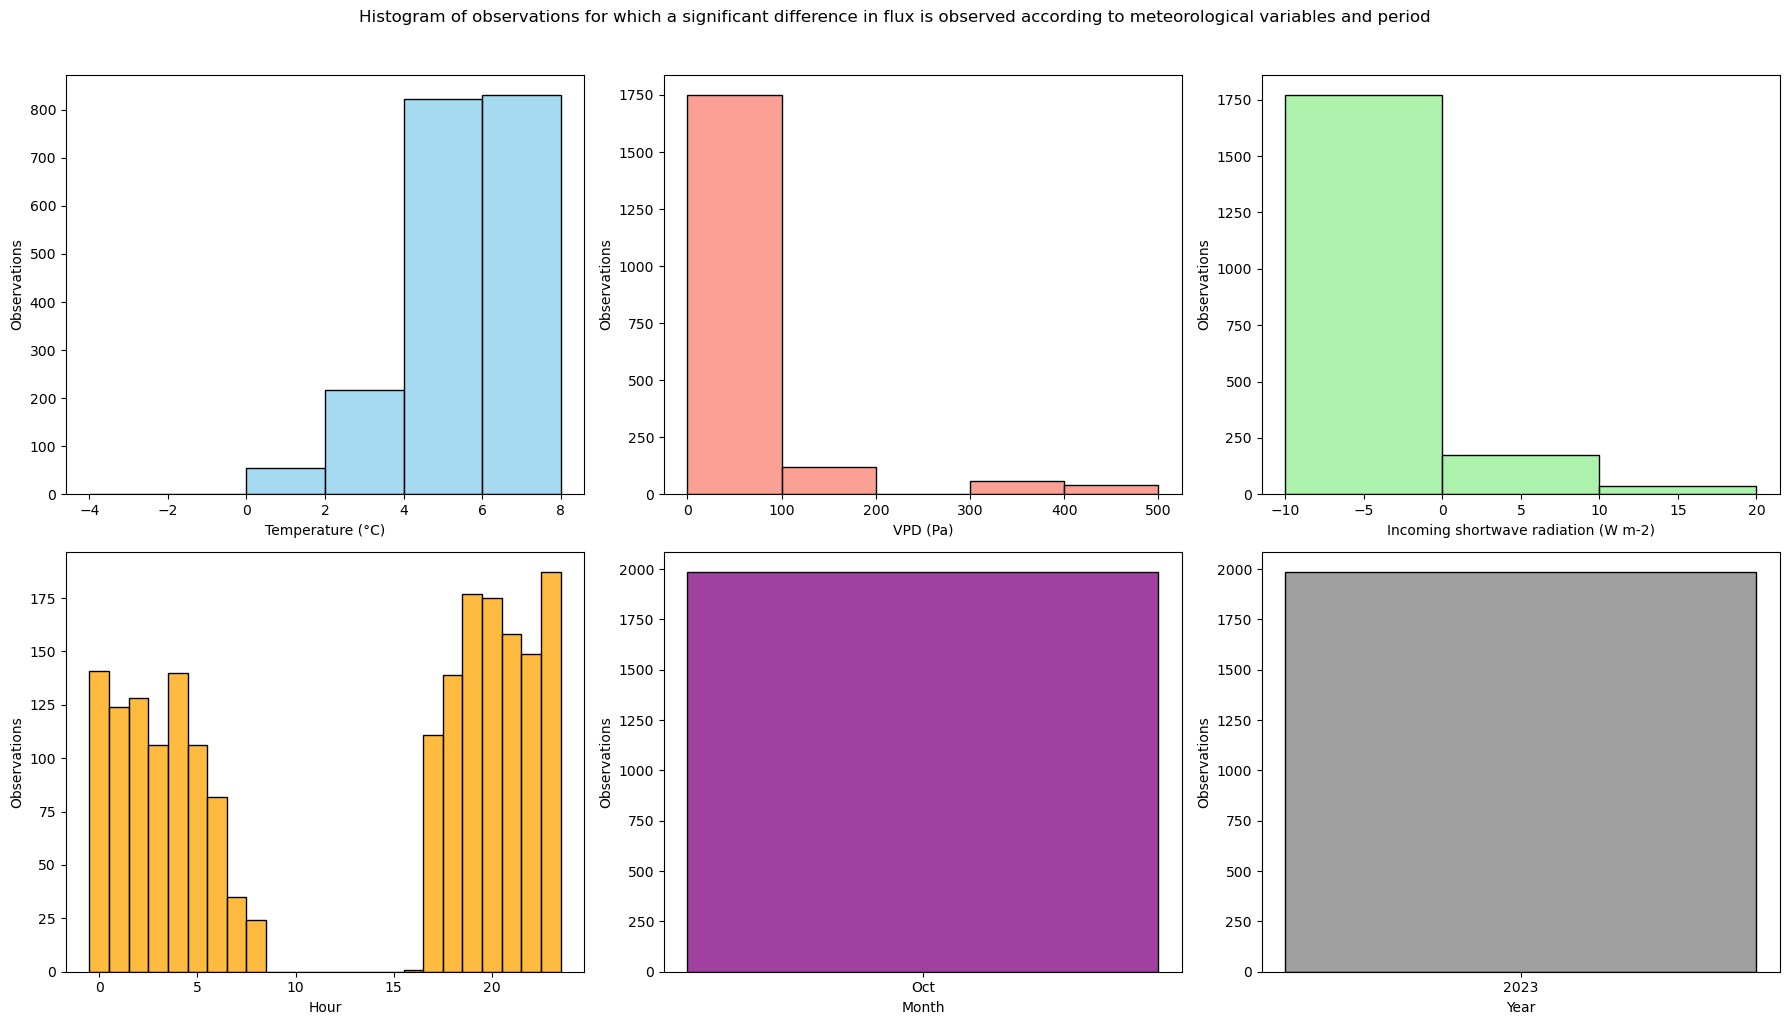

In [324]:
# Histograms of meteorological and temporal conditions for bins with significant sector differences
fig = FFP_analys.hist_significant(bin_significant_RECO, summary_df_RECO, 'Other > Wetland')
plt.show()

There are 23 bins with similar meteorological conditions where the Reco of the wetland is significantly lower than the other observations. This occured at specific times : in nights of October 2023, for low temperatures and high humidity. The median Reco of the fluxes where the wetland contributed the most is 2.10 gC/m2/day, while it is 2.13 gC/m2/day for the rest of the measured fluxes.

In [264]:
# Separate significant bins with Other > Wetland
bins_wetland = [bin_df for bin_df, summary in zip(bin_significant_RECO, summary_df_RECO.itertuples()) if summary.Direction == 'Other > Wetland']

In [246]:
# Concatenate the significant bins
all_bins = pd.concat(bins_wetland , ignore_index=True)
# Calculate the global median value
sectored_reco_df = all_bins.groupby('Sector')['RECO'].median().reset_index()
sectored_reco_df

,Sector,RECO
0,Other,0.044357
1,Wetland,0.043660


In [266]:
# Separate significant bins with Other < Wetland
bins_wetland = [bin_df for bin_df, summary in zip(bin_significant_RECO, summary_df_RECO.itertuples()) if summary.Direction == 'Other < Wetland']

In [267]:
# Concatenate the significant bins
all_bins = pd.concat(bins_wetland , ignore_index=True)
# Calculate the global median value
sectored_reco_df = all_bins.groupby('Sector')['RECO'].median().reset_index()
sectored_reco_df

,Sector,RECO
0,Other,0.024474
1,Wetland,0.027723


# Conclusion

To conclude, the wetland contributes very little and intermittently to the carbon exchanges measured by the Lautaret station. Its contribution can reach more than 2% in spring and winter. For periods where comparisons are possible (mostly in autumn), however, a significant impact of the wetland is observable. Results depend on specific meteorological conditions and years, as Reco can be higher or lower for the flux assigned to the wetland.